In [1]:
import torch
import numpy as np
import sys
sys.path.append("/home/sharfikeg/my_files/retIQA/ret/TReSM")
import torch
from sklearn.model_selection import train_test_split
torch.set_num_threads(24)
import json
import matplotlib.pyplot as plt

In [2]:
# CONSTANTS
img_num = {
        'csiq':     list(range(0, 30)),
        'kadid10k': list(range(0, 80)),
        'tid2013':  list(range(0, 25)),
        'koniq':    list(range(0, 10073)),
        'spaq':     list(range(0, 11125)),
        'pipal':    list(range(0, 200)),
        'biq':      list(range(0, 11989))
        }

botnet_pretrain="/home/sharfikeg/my_files/VIPNet/pretrained_model/botnet_model_best.pth.tar"
botnet_pretrain_classes=150
my_botnet_pretrain="/home/sharfikeg/my_files/retIQA/dc_ret/my_botnet_pretrain/checkpoint_model_best_heads16.pth"
my_botnet_pretrain_classes=125
logging_path="/home/sharfikeg/my_files/retIQA/dc_ret/DistorsionFeatureExtractor/results.csv"
tres_save_path="/extra_disk_1/sharfikeg/Save_TReS/"

tid2013_botnet_finetune="/home/sharfikeg/my_files/retIQA/dc_ret/finetune_botnet50_tid2013_checkpoints/checkpoint_model_best_heads16.pth"
tid2013_data_path="/home/s-kastryulin/data/tid2013/distorted_images/"
tid2013_ref_path="/home/s-kastryulin/data/tid2013/reference_images/"
tid2013_csv_path="/home/sharfikeg/my_files/retIQA/tid2013/tid2013_info.csv"
tid2013_uni_csv_path="/home/sharfikeg/my_files/retIQA/tid2013/tid2013_uni_info.csv"
tid2013_num_classes=120
k_tid=9

kadid10k_botnet_finetune="/home/sharfikeg/my_files/retIQA/dc_ret/finetune_botnet50_kadid10k_checkpoints/checkpoint_model_best_heads16.pth"
kadid10k_data_path="/home/sharfikeg/my_files/retIQA/kadid10k/distorted_images/"
kadid10k_ref_path="/home/sharfikeg/my_files/retIQA/kadid10k/reference_images/"
kadid10k_csv_path="/home/sharfikeg/my_files/retIQA/kadid10k/kadid10k_info.csv"
kadid10k_uni_csv_path="/home/sharfikeg/my_files/retIQA/kadid10k/kadid10k_uni_info.csv"
kadid10k_num_classes=125
k_kadid=9

csiq_botnet_finetune="/home/sharfikeg/my_files/retIQA/dc_ret/finetune_botnet50_csiq_checkpoints/checkpoint_model_best_heads16.pth"
csiq_data_path="/home/sharfikeg/my_files/retIQA/csiq/distorted_images/"
csiq_ref_path="/home/sharfikeg/my_files/retIQA/csiq/src_imgs/"
csiq_csv_path="/home/sharfikeg/my_files/retIQA/csiq/csiq_info.csv"
csiq_uni_csv_path="/home/sharfikeg/my_files/retIQA/csiq/csiq_uni_info.csv"
csiq_num_classes=30
k_csiq=9

koniq10k_data_path="/home/s-kastryulin/data/koniq10k/512x384/"
koniq10k_csv_path="/home/s-kastryulin/data/koniq10k/koniq10k_info.csv"
koniq10k_big_data_path="/home/s-kastryulin/data/koniq10k/1024x768/"
koniq10k_big_csv_path="/home/s-kastryulin/data/koniq10k/koniq10k_big_info.csv"
koniq10k_uni_csv_path="/home/s-kastryulin/data/koniq10k/koniq10k_uni_info.csv"
k_koniq=30

spaq_data_path="/extra_disk_1/sharfikeg/spaq/TestImage/"
spaq_csv_path="/extra_disk_1/sharfikeg/spaq/spaq_info.csv"
spaq_uni_csv_path="/home/sharfikeg/my_files/extra_disk_1/spaq/spaq_uni_info.csv"
k_spaq=50

biq_data_path="/home/sharfikeg/my_files/extra_disk_1/BIQ2021/Images/"
biq_csv_path="/home/sharfikeg/my_files/extra_disk_1/BIQ2021/biq_info.csv"
biq_uni_csv_path="/home/sharfikeg/my_files/extra_disk_1/BIQ2021/biq_uni_info.csv"
k_biq=30

pipal_data_path="/home/sharfikeg/my_files/extra_disk_1/pipal/train/Train_Dist/"
pipal_ref_path="/home/sharfikeg/my_files/extra_disk_1/pipal/train/Train_Ref/"
pipal_csv_path="/home/sharfikeg/my_files/extra_disk_1/pipal/train/pipal_info.csv"
pipal_uni_csv_path="/home/sharfikeg/my_files/extra_disk_1/pipal/train/pipal_uni_info.csv"
k_pipal=20

def str_2_float_list(pseudolist):
    intermediate = pseudolist.strip('][').split(', ')
    return list(map(float, intermediate))
def str_2_str_list(pseudolist):
    intermediate = pseudolist.strip('][').split(', ')
    return list(map(str, intermediate))

In [9]:
# PARAMS for TReSS/TReSM
seed = 10
dataset = 'csiq'
lr = '0.0002'
single_channel = True # else multi_channel
train_path = f"/extra_disk_1/sharfikeg/Save_TReSS/{dataset}_1_{seed}/k_3/lr_{lr}_lrratio1/no_finetune/single_return/train_LOSS_SRCC_1_{seed}.json" if single_channel else f"/extra_disk_1/sharfikeg/Save_TReSM/{dataset}_1_{seed}/k_3/lr_0.0002_lrratio1/no_finetune/single_return/train_LOSS_SRCC_1_{seed}.json"
test_path = f"/extra_disk_1/sharfikeg/Save_TReSS/{dataset}_1_{seed}/k_3/lr_{lr}_lrratio1/no_finetune/single_return/val_SRCC_PLCC_1_{seed}.json" if single_channel else f"/extra_disk_1/sharfikeg/Save_TReSM/{dataset}_1_{seed}/k_3/lr_0.0002_lrratio1/no_finetune/single_return/val_SRCC_PLCC_1_{seed}.json"
old_path = f"/extra_disk_1/sharfikeg/Save_TReSS/{dataset}_1_{seed}/k_3/lr_{lr}_lrratio1/no_finetune/single_return/PLCC_SRCC_1_{seed}.json" if single_channel else f"/extra_disk_1/sharfikeg/Save_TReSM/{dataset}_1_{seed}/k_3/lr_0.0002_lrratio1/no_finetune/single_return/PLCC_SRCC_1_{seed}.json"

In [5]:
# PARAMS for TReS
seed = 10
dataset = 'csiq'
train_path = f"/extra_disk_1/sharfikeg/Save_TReS/{dataset}_1_{seed}/sv/train_LOSS_SRCC_1_{seed}.json" 
test_path = f"/extra_disk_1/sharfikeg/Save_TReS/{dataset}_1_{seed}/sv/val_SRCC_PLCC_1_{seed}.json"
old_path = f"/extra_disk_1/sharfikeg/Save_TReS/{dataset}_1_{seed}/sv/PLCC_SRCC_1_{seed}.json"

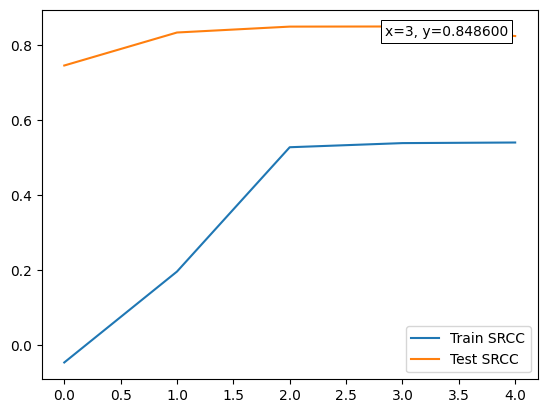

In [6]:
with open(train_path, "r") as f:
    train_scores = json.loads(f.read())
with open(test_path, "r") as f:
    test_scores = json.loads(f.read())

x,y= zip(*train_scores.items())
x,z= zip(*test_scores.items()) 

x = np.array(list(map(int, x)))
y = np.array(y)[:,1]
z = np.array(z)[:,0]

fig,ax = plt.subplots()
ax.plot(x , y, label="Train SRCC")
ax.plot(x , z, label="Test SRCC")

def annot_max(x,y, ax=None):
    xmax = x[np.argmax(y)]
    ymax = y.max()
    text= "x={}, y={:.6f}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)

annot_max(x,z)
plt.legend()
plt.show()

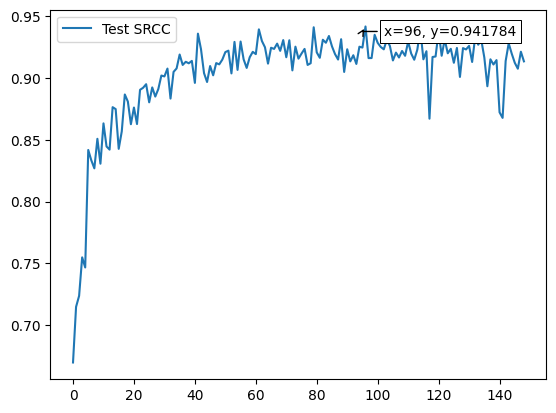

In [4]:
# oldy
with open(old_path, "r") as f:
    test_scores = json.loads(f.read())

x,z= zip(*test_scores.items()) 

x = np.array(list(map(int, x)))
z = np.array(z)[:,0]

fig,ax = plt.subplots()
ax.plot(x , z, label="Test SRCC")

def annot_max(x,y, ax=None):
    xmax = x[np.argmax(y)]
    ymax = y.max()
    text= "x={}, y={:.6f}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)

annot_max(x,z)
plt.legend()
plt.show()